In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE

from joblib import dump, load
import mlflow
import dagshub

In [2]:
dagshub.init("Projet7", "alexandre", mlflow=True)

Repository initialized!

In [3]:
mlflow.set_tracking_uri("https://dagshub.com/alexandre/Projet7.mlflow")

In [4]:
mlflow.set_experiment("LightGbm")

<Experiment: artifact_location='mlflow-artifacts:/187e727dd9bc40fba99274f5c4d207d3', creation_time=1692258841367, experiment_id='2', last_update_time=1692258841367, lifecycle_stage='active', name='LightGbm', tags={}>

In [5]:
# Chargement de base de données
df = pd.read_csv("../Data/Processed/fichier_LGBM.csv", index_col="SK_ID_CURR")

In [6]:
df.head()

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.060749,0.083037,0.139376,0.262949,-9461,-637.0,24700.5,-2120,351000.0,406597.5,1.0
100003,0.027598,0.311267,0.509353,0.622246,-16765,-1188.0,35698.5,-291,1129500.0,1293502.5,0.0
100004,0.050000,0.501964,0.729567,0.555912,-19046,-225.0,6750.0,-2531,135000.0,135000.0,0.0
100006,0.094941,0.501964,0.509353,0.650442,-19005,-3039.0,29686.5,-2437,297000.0,312682.5,0.0
100007,0.042623,0.501964,0.509353,0.322738,-19932,-3038.0,21865.5,-3458,513000.0,513000.0,0.0


In [7]:
# Définir la fonction de perte personnalisée
def custom_loss(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fn_weight = 10.0  # poids pour les faux négatifs
    fp_weight = 10.0  # poids pour les faux positifs
    return cm[0, 1] * fp_weight + cm[1, 0] * fn_weight

In [8]:
# Fonction d'évaluation
custom_scorer = make_scorer(custom_loss, greater_is_better=False)

In [9]:
# Séparer les données d'entraînement et de test
train_test_data = df.dropna(subset=["TARGET"])
X = train_test_data.drop(columns=["TARGET"])
y = train_test_data["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
# Initialiser le DummyClassifier
dummy_clf = DummyClassifier(
    strategy="most_frequent"
)  # ou une autre stratégie de votre choix

# Former le modèle avec les données d'entraînement
dummy_clf.fit(X_train, y_train)

# Prédire avec le DummyClassifier
y_pred_dummy = dummy_clf.predict(X_test)

# Calculer les métriques pour le DummyClassifier
roc_auc_dummy = roc_auc_score(y_test, y_pred_dummy)
cm_dummy = confusion_matrix(y_test, y_pred_dummy)

# Enregistrement de la matrice de confusion pour le DummyClassifier
path_cm_dummy = "../src/models/confusion_matrix_dummy.txt"
with open(path_cm_dummy, "w") as f:
    f.write(str(cm_dummy))

# Début de l'exécution MLflow pour le modèle Dummy
with mlflow.start_run(run_name="Dummy_LGBM") as run:
    # Enregistrer les métriques pour le DummyClassifier
    mlflow.log_metric("roc_auc_dummy", roc_auc_dummy)

    # Enregistrer la matrice de confusion en tant qu'artefact
    mlflow.log_artifact(path_cm_dummy)

    # Enregistrer le modèle DummyClassifier
    mlflow.sklearn.log_model(dummy_clf, "dummy_model")

In [11]:
print("ROC AUC =", roc_auc_dummy)
print(cm_dummy)

ROC AUC = 0.5
[[56502     0]
 [ 4992     0]]


In [12]:
# Créer un modèle LightGBM
model_lgb = lgb.LGBMClassifier()

# Utilisation d'imPipeline pour inclure SMOTE
pipeline_lgb = imPipeline([("smote", SMOTE()), ("lgb", model_lgb)])

# Paramètres à tester pour le LightGBM
param_grid_lgb = {
    "lgb__n_estimators": [65, 70, 80, 100],
    "lgb__max_depth": [8, 10, 12, 15, 17, 20],
    "lgb__learning_rate": [0.1],
    "lgb__num_leaves": [10, 15, 20, 30],
    "lgb__objective": ["binary"],
    "lgb__boosting_type": ["gbdt"],
    "lgb__random_state": [42],
}

# Création du GridSearch pour le LightGBM
grid_search_lgb = GridSearchCV(
    estimator=pipeline_lgb,
    param_grid=param_grid_lgb,
    scoring=custom_scorer,
    cv=3,
    n_jobs=-1,
)

# Adapter le modèle avec LightGBM
grid_search_lgb.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred_lgb = grid_search_lgb.predict(X_test)

# Calculer les métriques pour LightGBM
roc_auc = roc_auc_score(y_test, y_pred_lgb)
accuracy = accuracy_score(y_test, y_pred_lgb)
score_matrix = custom_loss(y_test, y_pred_lgb)
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

In [13]:
print("ROC AUC: ", roc_auc)
print("ACCURACY: ", accuracy)
print("SCORE MATRIX: ", score_matrix)
print(cm_lgb)

ROC AUC:  0.6226046520987685
ACCURACY:  0.749634110644941
SCORE MATRIX:  153960.0
[[43747 12755]
 [ 2641  2351]]


In [14]:
cm_lgb

array([[43747, 12755],
       [ 2641,  2351]], dtype=int64)

In [15]:
grid_search_lgb.best_estimator_.named_steps["lgb"].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 20,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 30,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [16]:
with open("../src/models/confusion_matrix_lgbm.txt", "w") as f:
    f.write(str(cm_lgb))


# Démarrez une nouvelle exécution MLflow
with mlflow.start_run(run_name="LightGbm") as run:
    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("ROC AUC Score", roc_auc)
    mlflow.log_metric("ACCURACY", accuracy)
    mlflow.log_metric("SCORE MATRIX", score_matrix)

    mlflow.log_artifact("../src/models/confusion_matrix_lgbm.txt")

    # Enregistrer les paramètres
    mlflow.log_params(grid_search_lgb.best_estimator_.named_steps["lgb"].get_params())

    # Enregistrement du modèle formé dans MLflow
    mlflow.sklearn.log_model(grid_search_lgb.best_estimator_, "LightGbm")

c:\Users\arken\anaconda3\envs\mon_projet7_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\arken\anaconda3\envs\mon_projet7_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


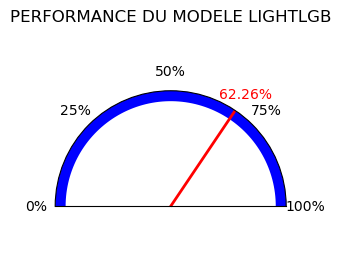

In [17]:
def draw_gauge(auc_score):
    # Normaliser le score entre 0 et 1
    normalized_score = auc_score / 100

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge (demi-cercle supérieur)
    arc = np.linspace(0, np.pi, 100)
    r = np.full(100, 0.6)
    ax.plot(arc, r, color="blue", linewidth=15)

    # Dessiner l'aiguille de la jauge
    theta = np.pi - normalized_score * 0.5 * np.pi
    ax.plot([theta, theta], [0, 0.6], color="red", linewidth=2)

    # Marquer le score sur l'aiguille
    ax.text(theta, 0.7, f"{auc_score:.2f}%", color="red", ha="center", va="center")

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])
    ax.set_title("PERFORMANCE DU MODELE LIGHTLGB", va="bottom")
    fig.savefig("../src/utils/images/jauge_Random_Forest.png")

    plt.show()


auc_score = roc_auc * 100
draw_gauge(auc_score)